In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import model_selection, svm, metrics, neighbors, linear_model, tree, ensemble
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import itertools
from sklearn.decomposition import PCA

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np 

def load_file(file_name):
    with open(file_name, 'rb') as file:
        return np.load(file)        

In [3]:
folder_save = '../dataset'
scaled_matrix = load_file(f"{folder_save}/scale_matrix.npy")

In [4]:
selected_customers = pd.read_csv('../dataset/selected_customers.csv')

# Phân cụm khách hàng

### Tìm số lượng cụm

In [26]:
silhouette_values = []

for n_clusters in range(3,15):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    silhouette_values.append(silhouette_avg)

    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.11891705742290348
For n_clusters = 4 The average silhouette_score is : 0.1336296365578207
For n_clusters = 5 The average silhouette_score is : 0.12616671747771122
For n_clusters = 6 The average silhouette_score is : 0.14355579618823877
For n_clusters = 7 The average silhouette_score is : 0.15095468179747915
For n_clusters = 8 The average silhouette_score is : 0.1714968067150676
For n_clusters = 9 The average silhouette_score is : 0.18005407159956163
For n_clusters = 10 The average silhouette_score is : 0.18540823416447377
For n_clusters = 11 The average silhouette_score is : 0.18637166110684916
For n_clusters = 12 The average silhouette_score is : 0.19178577940855435
For n_clusters = 13 The average silhouette_score is : 0.17789789465262038
For n_clusters = 14 The average silhouette_score is : 0.18023699136463842


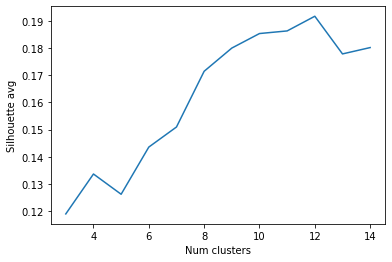

In [27]:
plt.plot(list(range(3,15)), silhouette_values)
plt.xlabel("Num clusters")
plt.ylabel("Silhouette avg")
plt.show()

### Chọn số lượng cụm là 12

In [28]:
n_clusters = 12
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score for silhouette {:<.3f}'.format(silhouette_avg))

score for silhouette 0.193


In [29]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['Number of values']).T

,9,5,8,6,1,3,10,11,0,4,2,7
Number of values,1400,393,371,311,286,273,207,188,123,10,7,7


### Đánh giá chất lượng của phân tách thông qua các điểm Silouhette trong các cụm khác nhau

In [30]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)

        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))

        y_lower = y_upper + 10  

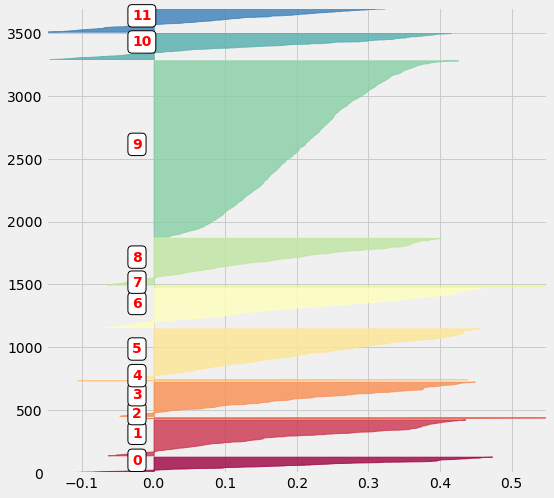

In [31]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

In [32]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

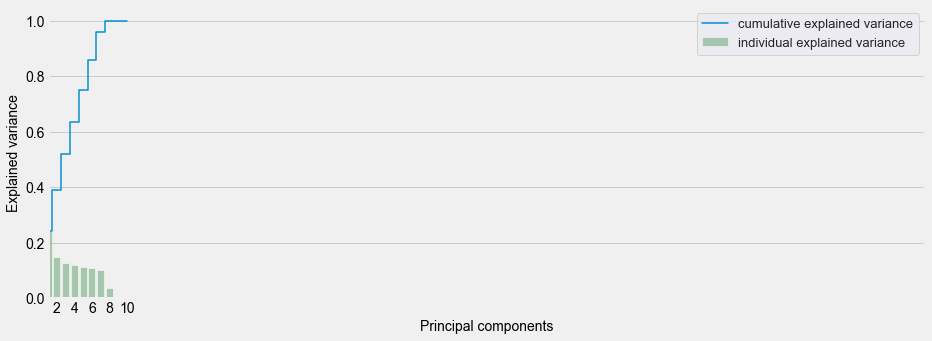

In [33]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(scaled_matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,scaled_matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper right', fontsize = 13);

In [34]:
pca = PCA(n_components=7)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

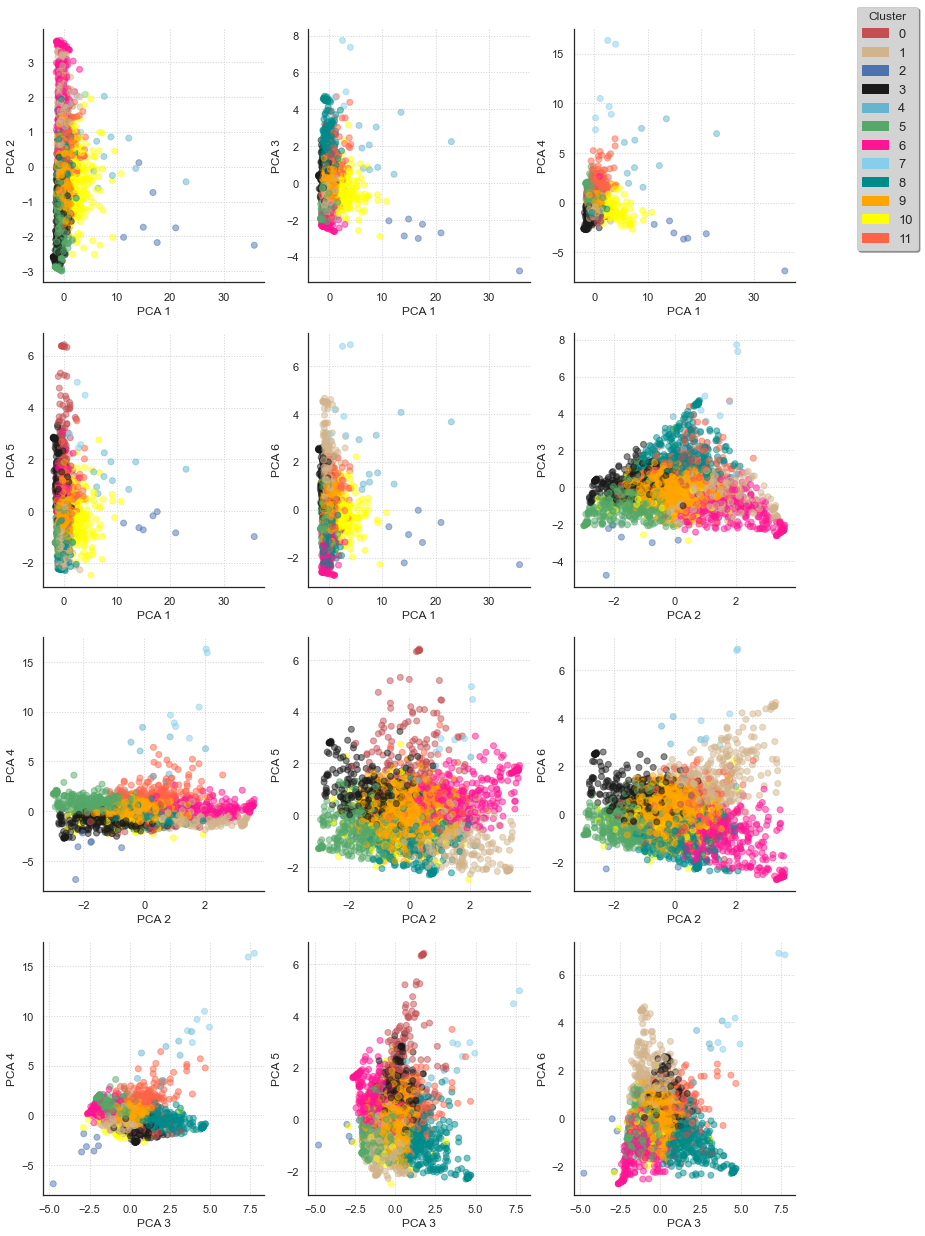

In [35]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,20))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

# Hình thái khách hàng

In [36]:
selected_customers.loc[:, 'cluster'] = clusters_clients
selected_customers

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,cluster
0,12347.0,5,382.52,711.79,508.252,2541.26,4.163289,9.528344,11.468327,13.861628,34.009507,26.968905,9
1,12348.0,4,187.44,652.80,359.310,1437.24,2.905569,0.000000,44.632768,0.000000,0.000000,52.461663,3
2,12350.0,1,294.40,294.40,294.400,294.40,6.929348,0.000000,6.351902,31.691576,0.000000,55.027174,5
3,12352.0,5,104.35,296.50,206.736,1033.68,1.436615,28.693600,0.986766,6.762248,30.086681,32.034092,9
4,12353.0,1,89.00,89.00,89.000,89.00,0.000000,22.359551,0.000000,19.887640,0.000000,57.752809,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3571,18280.0,1,180.60,180.60,180.600,180.60,11.018826,23.006645,0.000000,41.140642,24.833887,0.000000,8
3572,18281.0,1,80.82,80.82,80.820,80.82,0.000000,0.000000,18.708241,18.930958,0.000000,62.360802,5
3573,18282.0,1,98.76,98.76,98.760,98.76,0.000000,0.000000,19.349939,17.922236,13.669502,49.058323,5
3574,18283.0,10,2.50,192.80,108.088,1080.88,9.804049,2.257420,15.971246,30.259603,7.493894,34.213789,9


In [37]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3576


In [38]:
liste_index = []
for i in range(6):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] == merged_df[column].max()].index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]

In [39]:
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0','categ_1', 'categ_2', 'categ_3', 'categ_4','categ_5', 'size']]

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,size
0,0.0,2.430894,208.384472,309.622846,258.518830,626.715122,46.474940,9.877168,8.206399,10.313916,7.319223,17.808353,123
1,6.0,2.434084,193.436206,305.770096,243.605663,620.126141,3.839440,55.471287,4.492816,9.842391,11.158513,15.213698,311
2,3.0,2.080586,187.905788,265.541722,224.234926,477.945421,4.299682,5.824471,47.852647,12.389123,6.902922,22.731154,273
3,8.0,2.566038,193.225660,328.153450,257.472928,703.508679,4.966511,9.407150,7.177415,51.391225,8.617945,18.439754,371
4,1.0,2.129371,192.475280,305.314266,245.350816,581.491783,3.331597,11.444628,6.176509,13.085860,50.086907,15.936557,286
5,5.0,2.213740,177.071934,256.931196,215.416345,490.571552,3.060962,7.287633,8.685777,9.876418,6.175839,64.917158,393
6,9.0,3.147143,219.824071,437.831564,321.836673,997.624693,6.569505,14.645558,12.516155,19.171648,15.814036,31.286551,1400
7,10.0,1.937198,942.257150,1330.349952,1106.929693,2171.807729,7.868093,13.552068,10.923227,20.770671,15.813292,31.072976,207
8,2.0,1.285714,4766.842857,5012.702857,4889.772857,6220.454286,13.440695,20.745218,8.845329,13.620254,17.063076,26.285428,7
9,11.0,16.031915,86.795532,1133.610426,454.509494,6847.131011,8.201750,15.763680,9.809597,22.466126,15.409270,28.369492,188


### Phân tích tính chất của từng cụm thông qua biểu đồ Rada

In [40]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid[:-1], labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

In [42]:
n_clusters

12

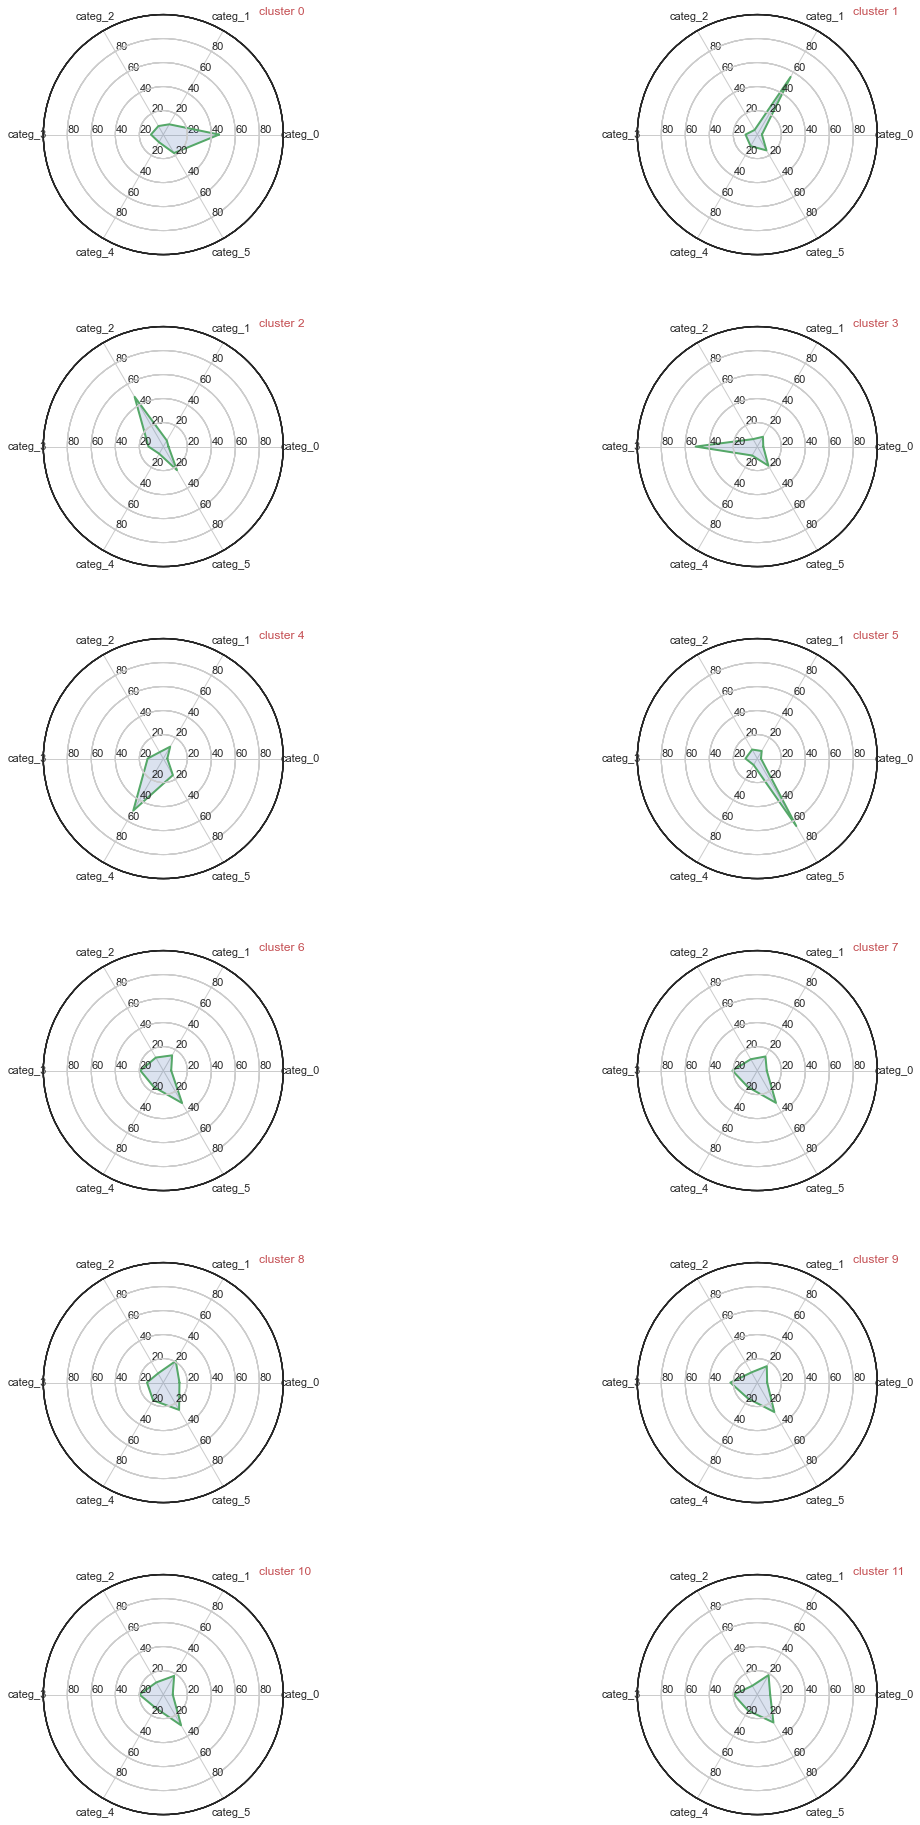

In [43]:
fig = plt.figure(figsize=(15,20))

# attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
# ranges = [[0.01, 10], [0.01, 3000], [0.01, 6000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]

attributes = ['categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4','categ_5']
ranges = [[0.01, 100], [0.01, 100], [0.01, 100], [0.01, 100], [0.01, 100],[0.01, 100]]
index  = range(12)

n_groups = n_clusters ; i_cols = 2
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%2 ; iy = i_rows - ind//2
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    data = np.array(merged_df.loc[index[ind], attributes])
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'g', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster {}'.format(index[ind]), color = 'r')
    ind += 1 

In [44]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [45]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4','categ_5' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [46]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

In [47]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## KNN

In [49]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 81.56 % 


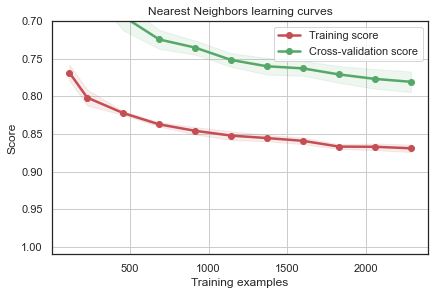

In [50]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Decision Tree

In [51]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 82.54 % 


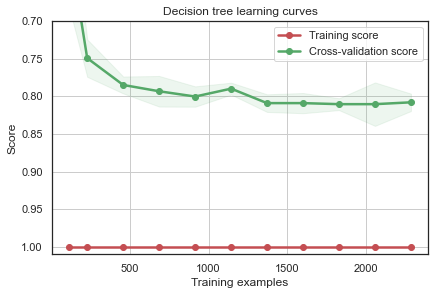

In [52]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Random forest

In [53]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 88.55 % 


In [54]:
rf.grid.best_estimator_

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=60)

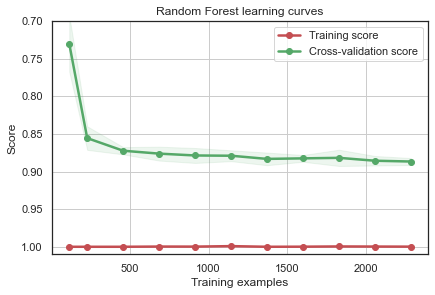

In [55]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Gradient Boosting

In [56]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 88.55 % 


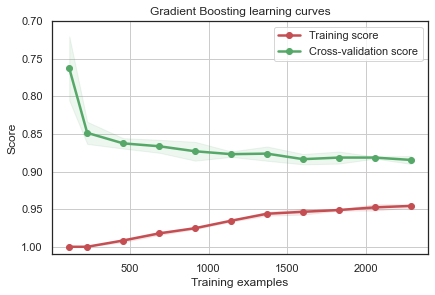

In [57]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [58]:
rf.grid.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 60}

In [59]:
gb.grid.best_params_

{'n_estimators': 30}

In [60]:
knn.grid.best_params_

{'n_neighbors': 4}

In [61]:
tr.grid.best_params_

{'criterion': 'gini', 'max_features': 'sqrt'}

In [62]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)

In [63]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')  

In [64]:
votingC = votingC.fit(X_train, Y_train)

In [65]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 89.66 % 


In [66]:
import pickle

In [67]:
def save_model(model_name,model):
    with open(f'../weight_model/{model_name}.pkl','wb') as f:
        pickle.dump(model,f)

In [68]:
save_model('votingC',votingC)

In [69]:
def save_csv(file_name,data):
    data.to_csv(f'../dataset/{file_name}.csv',index=False)

In [70]:
save_csv('X_train',X_train)
save_csv('Y_train',Y_train)
save_csv('X_val',X_test)
save_csv('Y_val',Y_test)

# Prediciton for new customer

In [93]:
import pickle

In [76]:
selected_customers_test = pd.read_csv('../dataset/selected_customers_test.csv')

In [77]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4','categ_5' ]
X_test = selected_customers_test[columns]

In [94]:
with open('../dataset/scaler_method.pkl','rb') as file:
    scaler_method = pickle.load(file)

In [99]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4','categ_5']
matrix_test = selected_customers_test[list_cols].to_numpy()
scaled_test_matrix = scaler_method.transform(matrix_test)

In [100]:
y_test = kmeans.predict(scaled_test_matrix)

In [92]:
y_test_pred = votingC.predict(X_test)

In [ ]:
y_test = kmeans.predict()

In [102]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89        65
           1       0.97      0.91      0.94       271
           2       0.50      1.00      0.67         4
           3       0.94      0.93      0.93       185
           4       0.33      0.11      0.17         9
           5       0.95      0.93      0.94       240
           6       0.94      0.97      0.96       159
           7       0.00      0.00      0.00         2
           8       0.95      0.96      0.96       389
           9       0.93      0.97      0.95       999
          10       0.83      0.90      0.86       181
          11       0.00      0.00      0.00        29

    accuracy                           0.93      2533
   macro avg       0.69      0.71      0.69      2533
weighted avg       0.92      0.93      0.92      2533



In [108]:
save_csv('X_test',X_test)
save_csv('y_test',pd.DataFrame(y_test_pred,columns=['y_predict']))